# AutoEncoder Fashion MNIST

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [1]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.datasets import fashion_mnist

np.random.seed(20230629)
tf.random.set_seed(20230629)

Download the Fashion MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), constant_values=0)
train_images = train_images.reshape((len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

4422102/4422102 [==============================] - 0s 0us/step


Show sample images for 10 categories.

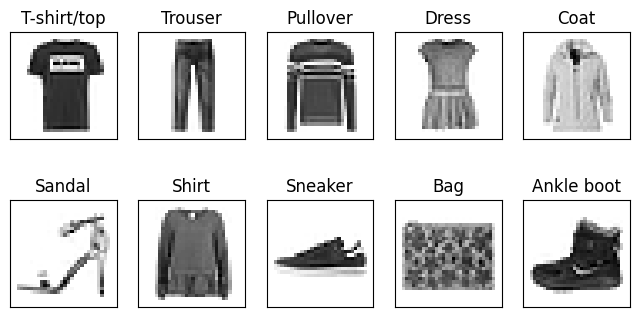

In [3]:
sample_indices = []
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    for c, (image, label) in enumerate(zip(train_images, train_labels)):
        if np.argmax(label) == i:
            sample_indices.append(c)
            break

fig = plt.figure(figsize=(8, 4))
for i in range(10):
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(labels[i])
    subplot.imshow(train_images[sample_indices[i]].reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

Define the encoder with convolutional filters.

In [4]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Reshape((32, 32, 1), input_shape=(32*32,), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(2, name='embedding_space'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv_filter1 (Conv2D)       (None, 16, 16, 32)        320       
                                                                 
 conv_filter2 (Conv2D)       (None, 8, 8, 64)          18496     
                                                                 
 conv_filter3 (Conv2D)       (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 embedding_space (Dense)     (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

Define the decoder with transoposed convolutional filters.

In [5]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(4 * 4 * 128, input_shape=(2, ), name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape2'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                        activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                        activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand (Dense)              (None, 2048)              6144      
                                                                 
 reshape2 (Reshape)          (None, 4, 4, 128)         0         
                                                                 
 conv_transpose1 (Conv2DTran  (None, 8, 8, 64)         73792     
 spose)                                                          
                                                                 
 conv_transpose2 (Conv2DTran  (None, 16, 16, 32)       18464     
 spose)                                                          
                                                                 
 conv_transpose3 (Conv2DTran  (None, 32, 32, 1)        289       
 spose)                                                          
                                                           

Define AutoEncoder by combining the encoder and the decoder.

In [6]:
model_input = tf.keras.Input(shape=(32*32,))
model = models.Model(model_input, decoder(encoder(model_input)))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 encoder (Sequential)        (None, 2)                 96770     
                                                                 
 decoder (Sequential)        (None, 1024)              98689     
                                                                 
Total params: 195,459
Trainable params: 195,459
Non-trainable params: 0
_________________________________________________________________


Compile the model using the Adam optimizer, and MSE as a loss function.

In [7]:
model.compile(optimizer='adam', loss='mse')

Define a function to show reconstructed images.

In [8]:
def show_result():
    results = model.predict(train_images[sample_indices], verbose=0)

    fig = plt.figure(figsize=(16, 2.7))
    for i in range(10):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(train_images[sample_indices[i]].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((32, 32)),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

Train the model for a single epoch with 30,000 images, and show the intermediate result.

300/300 [==============================] - 17s 5ms/step - loss: 0.0563


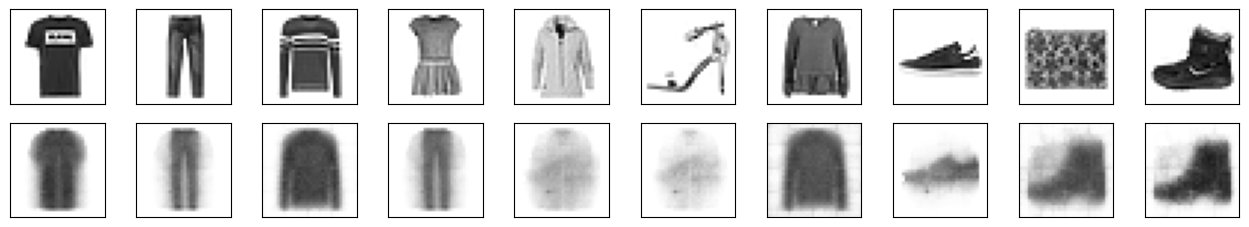

In [9]:
history = model.fit(train_images[:30000], train_images[:30000],
                    batch_size=100, epochs=1)
show_result()

Train the model for additional epochs, and show the final result.

Epoch 1/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0296
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0267
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0253
Epoch 4/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0245
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0239
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0235
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0231
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 0.0229
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0227
Epoch 10/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0225
Epoch 11/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0223
Epoch 12/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0222
Epoch 13/50
600/600 [====

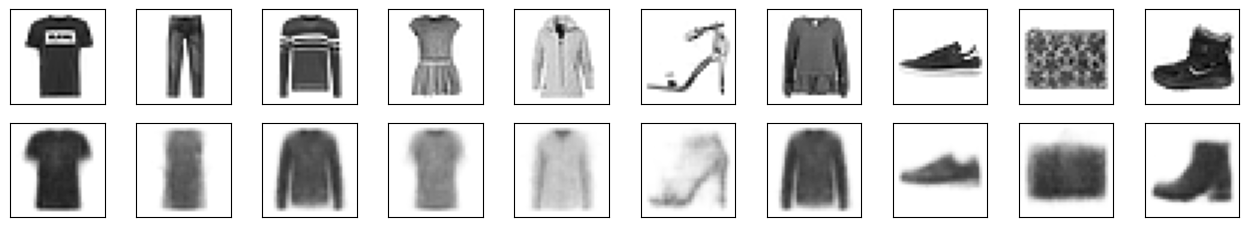

In [10]:
%%time
history = model.fit(train_images, train_images,
                    batch_size=100, epochs=50)
show_result()

Show the embeddings of training data.

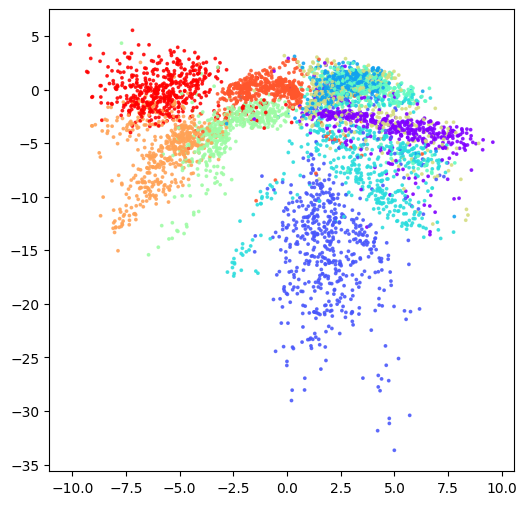

In [11]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstruction images over the embedding space.

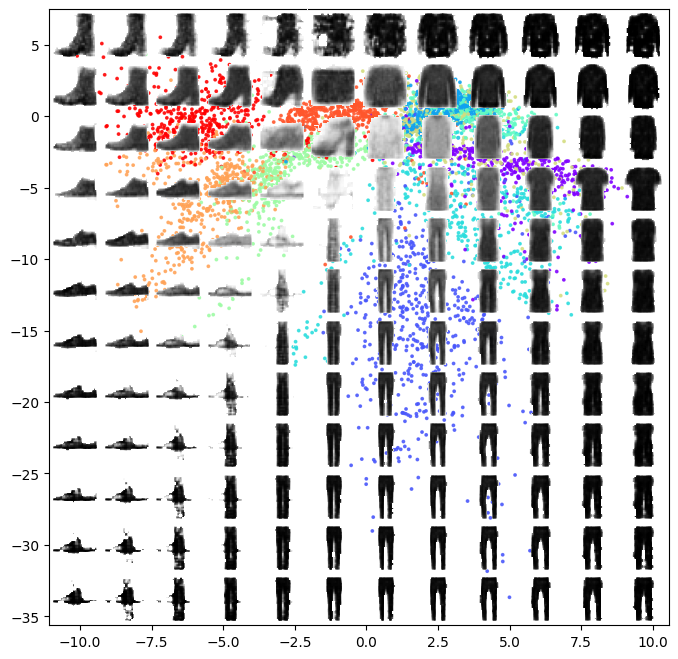

In [12]:
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), 12)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), 12)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid, verbose=0)

fig = plt.figure(figsize=(8, 8))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                cmap='rainbow',
                c=example_labels, alpha=0.8, s=3)

my_cmap = copy.copy(colormaps['gray_r'])
my_cmap.set_bad(alpha=0)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(12*12):
    subplot = fig.add_subplot(12, 12, i + 1)
    subplot.axis('off')
    img = map(lambda x: np.nan if x < 0.02 else x, reconstructions[i])
    subplot.imshow(np.array(list(img)).reshape((32, 32)),
                   vmin=0, vmax=1, cmap=my_cmap)

Show reconstructed images from a circile on the embedding space.

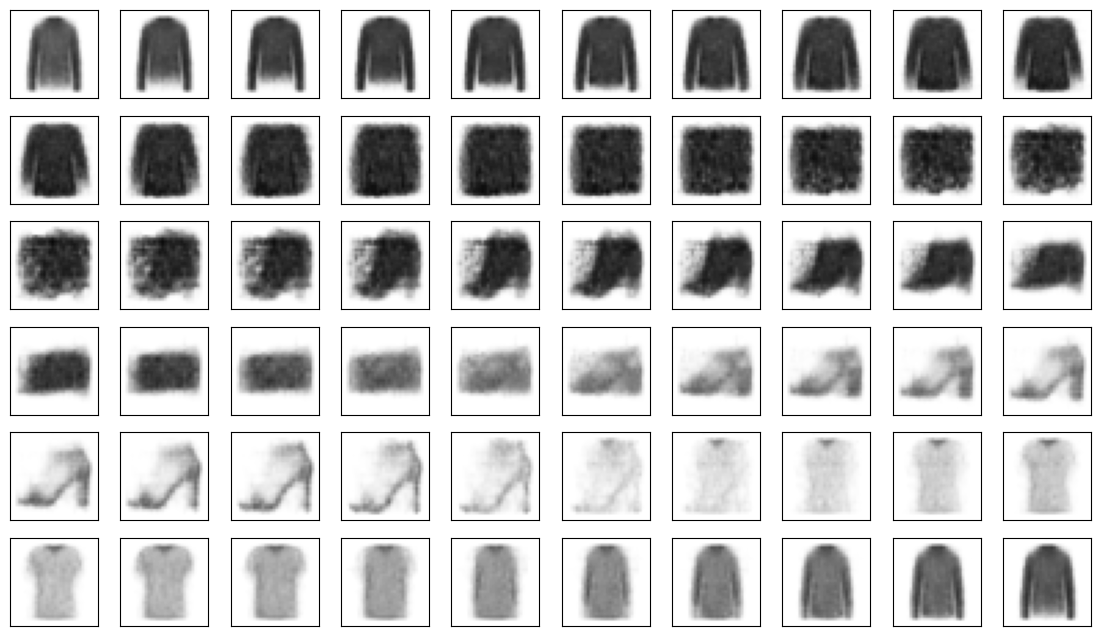

In [13]:
samples = []
for theta in np.linspace(0, 2*np.pi, 60):
    samples.append([3*np.cos(theta), 3*np.sin(theta)])
reconstructions = decoder.predict(samples, verbose=0)

fig = plt.figure(figsize=(14, 8))
for i in range(60):
    subplot = fig.add_subplot(6, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(reconstructions[i].reshape((32, 32)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)